# Error metrics (CV) as a function of the signal to noise ratio
In this NoteBook the main objective is to assess the error metric as a function of the signal to noise ratio

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csss
import matplotlib.pyplot as plt
import datetime as dt
import pickle as pk
from imp import reload
import copy
from time import time as t_clock
from copy import deepcopy
import seaborn as sns
from csss.SolarDisagg import createTempInput
from csss.utilities import Setup_load as SetUp_load, unique_list,load_pkl


Loading Load and Weather data. Cleaning the data and updating.

In [11]:
#%% Loading the data
Setup_load = deepcopy(SetUp_load())
Setup_load.QueryOrLoad()
load_data, load_data_2, weather, grouped_data, ids, solar_ids, homeids  = Setup_load.load_setup()
#%% Remove those solar houses that have generation = 0 for continous N_obs.
N_obs_day = 96 # number of observations in one day.
N_obs = 3*N_obs_day
remove = []
for i in solar_ids['solar']:
    df = grouped_data.get_group(i)
    roll_mean = df.gen.rolling(N_obs).mean()
    if np.nansum(roll_mean < 0.001) > 0:
        remove.append(i)
len(remove)

## Update the data accordingly
ids = list(set(ids) - set(remove))
load_data = load_data[~load_data['dataid'].isin(remove)]
solar_ids['solar'] = list(set(solar_ids['solar']) - set(remove))
solar_ids['nosolar'] = list(set(solar_ids['nosolar']) - set(remove))
grouped_data = load_data.groupby("dataid")

reading 61047030 values from csv took 7.69 seconds
There are 167 homes with complete data
105 homes solar
62 homes with no solar


Loading the results

In [4]:
## 30 days chunks
fp = 'Validarion/data/results_sd_1year_scen_out_30days_chunck.pkl'
def generate_df_res(fp):
    
    with open(fp,"rb") as f:    
       scen_out,df_out,N_proxy,rs = pk.load(f)
    DFout = pd.DataFrame()
    months = np.arange(1,13)
#    months = np.arange(1,36)
    for m in months:
        if isinstance(df_out[(1,67,m)], pd.DataFrame):
            DFout = pd.concat([DFout,df_out[(1,67,m)]])
        
    ## calculate average cv_pos across the year
    
    ids = DFout.index.levels[0][1:]
    N_houses = DFout.index.levels[1][0]
    n_scen = DFout.index.levels[3]
    models = DFout.index.levels[2]
    df_res_30 = pd.Series(index = ids)#, columns = ['res_30'])
    
    for idd in ids:
        generation = deepcopy(grouped_data.get_group(idd).gen[grouped_data.get_group(idd).index < '2016-01-01']) 
        gm = generation[generation > 0.05*generation.mean()].mean()
        df_res_30.loc[idd] = np.abs(np.mean(DFout.loc[(idd,N_houses,models[2],n_scen)]['rmse_pos']))/gm 
    return df_res_30
df_res_30 = generate_df_res(fp)


In [5]:
## 1 year data
fp = 'Validarion/data/results_sd_1year.pkl'
with open(fp,"rb") as f:
    df_out,N_proxy_vec,rs_vec = pk.load(f)
df_out = df_out[(1,67)]

## dataframe generation
def get_1year_df(metric,df_out):
    ids = df_out.index.levels[0][1:]
    N_houses = df_out.index.levels[1][0]
    n_scen = df_out.index.levels[3][0]
    models = df_out.index.levels[2]
    model = 'tune_std'
    metric = metric
    index = unique_list(df_out[df_out['istunesys'] == False].index.get_level_values('dataid'))
    index.remove(0)
    df_res = pd.DataFrame(index = index, columns = models)
    for i in range(len(models)):
        model = models[i]    
        df_res.loc[:,model] = df_out.loc[(ids,N_houses,model,n_scen)][df_out['istunesys'] == False][metric].values
    if metric == 'mbe_pos':
        for idd in df_res.index:
            generation = deepcopy(grouped_data.get_group(idd).gen[grouped_data.get_group(idd).index < '2016-01-01']) 
            gm = generation[generation > 0.05*generation.mean()].mean()
            df_res.loc[idd] = df_res.loc[idd]/gm 

    if metric in ['cv_pos','cv'] :
        df_res = np.abs(df_res)
    df_res_year = deepcopy(df_res['tune_std'])
    ids = df_res_year.index
    return df_res_year,ids
metric = 'mbe_pos'
df_res_year,ids = get_1year_df(metric,df_out)

C:\Users\inno1\Anaconda3\envs\SolarDisaggregation\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\inno1\Anaconda3\envs\SolarDisaggregation\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\inno1\Anaconda3\envs\SolarDisaggregation\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Real SNR : Signal/Noise ratio

In [88]:
snr = pd.Series(index = ids)
for idd in ids:
    df_actual = grouped_data.get_group(idd)
    df_actual = df_actual[df_actual.index < '2016-01-01']
    mask = df_actual['gen'] > 0.05*df_actual['gen'].mean()
    snr.loc[idd] = np.square(np.linalg.norm(df_actual.gen[mask],2)/np.linalg.norm(df_actual.use[mask],2))

C:\Users\inno1\Anaconda3\envs\SolarDisaggregation\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\inno1\Anaconda3\envs\SolarDisaggregation\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\inno1\Anaconda3\envs\SolarDisaggregation\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


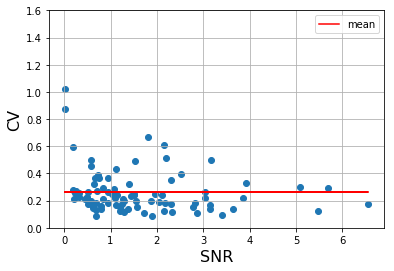

In [89]:
## CV Vs. snr
df_res_year,ids = get_1year_df('cv_pos',df_out)
plt.figure()
fts = 16
plt.scatter(snr,df_res_year, label = '')
plt.plot(snr,np.repeat(df_res_year.mean(), len(snr)), color = 'red', label = 'mean')
plt.grid(True)
plt.xlabel('SNR', fontsize = fts)
plt.ylabel('CV',fontsize = fts)
plt.legend()
plt.ylim([0,1.6])
# plt.show()
plt.savefig('figures/CV_1year_snr.png',bbox = 'tight')

C:\Users\inno1\Anaconda3\envs\SolarDisaggregation\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\inno1\Anaconda3\envs\SolarDisaggregation\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\inno1\Anaconda3\envs\SolarDisaggregation\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


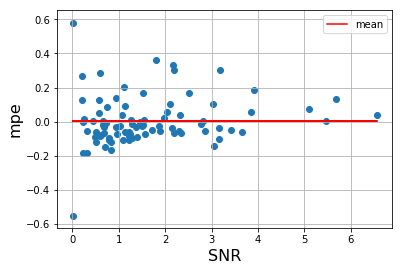

In [90]:
## Plot Mean Percentage Error Vs. snr
df_res_year,ids = get_1year_df('mbe_pos',df_out)
plt.figure()
fts = 16
plt.scatter(snr,df_res_year, label = '')
plt.plot(snr,np.repeat(df_res_year.mean(), len(snr)), color = 'red', label = 'mean')
plt.grid(True)
plt.xlabel('SNR', fontsize = fts)
plt.ylabel('mpe',fontsize = fts)
plt.legend()
# plt.ylim([0,1.6])
# plt.show()
plt.savefig('figures/mpe_1year_snr.png',bbox = 'tight')

### Comment: 
(percentage is still refered to the mean of solar generation excluding nighttime values.)
Mean Percentage Error decreases a little bit with snr and it has almost zero mean. I was expeting that almost all the error in CV is explained by the bias error. It would be interesting to compare the difference cv-mbe for each idd. 

C:\Users\inno1\Anaconda3\envs\SolarDisaggregation\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\inno1\Anaconda3\envs\SolarDisaggregation\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\inno1\Anaconda3\envs\SolarDisaggregation\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\inno1\Anaconda3\envs\SolarDisaggregation\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\inno1\Anaconda3\envs\SolarDisaggregation\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\inno1\Anaconda3\envs\SolarDisaggregation\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to mat

Text(0, 0.5, 'pmae - pmbe')

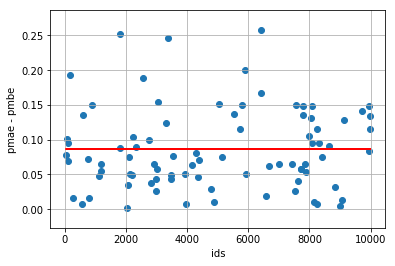

In [91]:
df_res_year,ids = get_1year_df('pmae_pos',df_out)
df_res_year_bias,ids = get_1year_df('mbe_pos',df_out)
plt.scatter(ids,-df_res_year-np.abs(df_res_year_bias)) # there is a negative sign on the pmae because the generation is taken as negative in the results
plt.plot(ids,np.repeat((-df_res_year-np.abs(df_res_year_bias)).mean(), len(snr)), color = 'red', label = 'mean')
plt.grid(True)
plt.xlabel('ids')
plt.ylabel('pmae - pmbe')

### Comment: 
(percentage is still refered to the mean of solar generation excluding nighttime values.)
I was expeting that almost all the error in MAE is explained by the bias error, due to attributing the wrong scaling factor. Instead there is an additive 10% on average. Could it be that the tuning alpha gets it weird sometimes? Not sure.


### Estimated SNR : Signal/Noise ratio

In [92]:
# 1 year
scen_out = load_pkl('Validarion/data/results_sd_1year_scen_out.pkl')[0]

In [95]:
snr_est = pd.Series(index = ids)
k=0
for idd in ids:
    df_actual = grouped_data.get_group(idd)
    df_actual = df_actual[df_actual.index < '2016-01-01']
#     mask = df_actual['gen'] > 0.05*df_actual['gen'].mean()
    solar_signal_est = -np.squeeze(np.asarray(scen_out['tuned_model_std'][idd]['source'].value))
    mask = solar_signal_est > 0.05*solar_signal_est.mean()
    solar_signal_est = solar_signal_est[mask] 
    use_signal_est   = df_actual['netload'].values[mask] + solar_signal_est
    snr_est.loc[idd] = np.square(np.linalg.norm(solar_signal_est,2)/np.linalg.norm(use_signal_est,2))

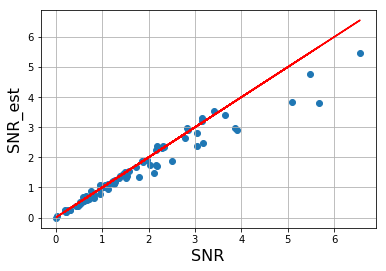

In [97]:
plt.close()
plt.figure()
fts = 16
plt.scatter(snr,snr_est)
plt.plot(snr,snr,color = 'red')
plt.grid(True)
plt.xlabel('SNR', fontsize = fts)
plt.ylabel('SNR_est',fontsize = fts)
# plt.show()
plt.savefig('figures/SNR_est_SNR.png',bbox = 'tight')